In [1]:
import torch
import torch.nn as nn
import loralib as lora
import numpy as np
#import matplotlib.pyplot as plt
import time
import os
import sys
import pandas as pd
import pickle
import random
import math
import copy
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
from datasets import load_dataset, load_metric
import copy
import transformers
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    EvalPrediction,
    HfArgumentParser,
    PretrainedConfig,
    Trainer,
    TrainingArguments,
    default_data_collator,
    set_seed,
    EarlyStoppingCallback,
)
from transformers.trainer_utils import get_last_checkpoint, is_main_process
from transformers.utils import check_min_version

/home/lab/anaconda3/envs/NLU/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def seed_everything(seed: int = 0):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

In [3]:
seed_everything(0)

In [ ]:
w_q_encoder_loraA_weights = []
w_q_encoder_loraB_weights = []
w_v_encoder_loraA_weights = []
w_v_encoder_loraB_weights = []
len_of_layers = 12  # len(SVD_model.roberta.encoder.layer)
with torch.no_grad():
    for i in range(len_of_layers):
        encoder_q_original_weight = SVD_model.roberta.encoder.layer[i].attention.self.query.weight.data.T
        encoder_v_original_weight = SVD_model.roberta.encoder.layer[i].attention.self.value.weight.data.T
        encoder_q_u, encoder_q_s, encoder_q_v = torch.linalg.svd(encoder_q_original_weight)
        encoder_v_u, encoder_v_s, encoder_v_v = torch.linalg.svd(encoder_v_original_weight)
        approx_rank = rank
        # w_q_encoder
        # torch.Size([768, rank])
        w_q_encoder_loraA_weights.append(
            encoder_q_u[:, :approx_rank] @ torch.diag(encoder_q_s[:approx_rank]).sqrt()
        )
        # torch.Size([rank, 768])
        w_q_encoder_loraB_weights.append(
            torch.diag(encoder_q_s[:approx_rank]).sqrt() @ encoder_q_v[:approx_rank, :]
        )
        # w_v_encoder
        w_v_encoder_loraA_weights.append(
            encoder_v_u[:, :approx_rank] @ torch.diag(encoder_v_s[:approx_rank]).sqrt()
        )
        w_v_encoder_loraB_weights.append(
            torch.diag(encoder_v_s[:approx_rank]).sqrt() @ encoder_v_v[:approx_rank, :]
        )
og_weight = SVD_model.roberta.encoder.layer[0].attention.self.query.weight.data.T
# insert_lora(SVD_model, 768, approx_rank, lora_alpha)
with torch.no_grad():
    for i in range(len_of_layers):
        SVD_model.roberta.encoder.layer[i].attention.self.query.lora_A.copy_(
            w_q_encoder_loraA_weights[i].transpose(0, 1)
        )
        SVD_model.roberta.encoder.layer[i].attention.self.query.lora_B.copy_(
            w_q_encoder_loraB_weights[i].transpose(0, 1)
        )
        SVD_model.roberta.encoder.layer[i].attention.self.value.lora_A.copy_(
            w_v_encoder_loraA_weights[i].transpose(0, 1)
        )
        SVD_model.roberta.encoder.layer[i].attention.self.value.lora_B.copy_(
            w_v_encoder_loraB_weights[i].transpose(0, 1)
        )

In [7]:
og_weight = model.roberta.encoder.layer[0].attention.self.query.weight.data
u,s,vt = torch.linalg.svd(og_weight)
print(og_weight,'\n',u@torch.diag(s)@vt)

tensor([[ 0.0732, -0.0019, -0.0901,  ...,  0.1035,  0.0895, -0.1039],
        [-0.0503,  0.2062,  0.0739,  ...,  0.0655,  0.0638,  0.1283],
        [ 0.0873,  0.0705, -0.0510,  ..., -0.0434, -0.0083,  0.1095],
        ...,
        [-0.1872,  0.0175, -0.0310,  ..., -0.0509,  0.1026, -0.1170],
        [-0.2543,  0.0437,  0.0641,  ...,  0.0709, -0.1043,  0.0117],
        [-0.0517, -0.0858,  0.1024,  ..., -0.1888,  0.0034, -0.0538]]) 
 tensor([[ 0.0732, -0.0019, -0.0901,  ...,  0.1035,  0.0895, -0.1039],
        [-0.0503,  0.2062,  0.0739,  ...,  0.0655,  0.0638,  0.1283],
        [ 0.0873,  0.0705, -0.0510,  ..., -0.0434, -0.0083,  0.1095],
        ...,
        [-0.1872,  0.0175, -0.0310,  ..., -0.0509,  0.1026, -0.1170],
        [-0.2543,  0.0437,  0.0641,  ...,  0.0709, -0.1043,  0.0117],
        [-0.0517, -0.0858,  0.1024,  ..., -0.1888,  0.0034, -0.0538]])


In [8]:
df_s = pd.DataFrame(s.numpy())
df_s

,0
0,10.196619
1,9.957478
2,8.467140
3,7.959620
4,7.876126
...,...
763,0.008453
764,0.007697
765,0.005820
766,0.005240


In [9]:
df_s[0]

0      10.196619
1       9.957478
2       8.467140
3       7.959620
4       7.876126
         ...    
763     0.008453
764     0.007697
765     0.005820
766     0.005240
767     0.001830
Name: 0, Length: 768, dtype: float32

<AxesSubplot:>

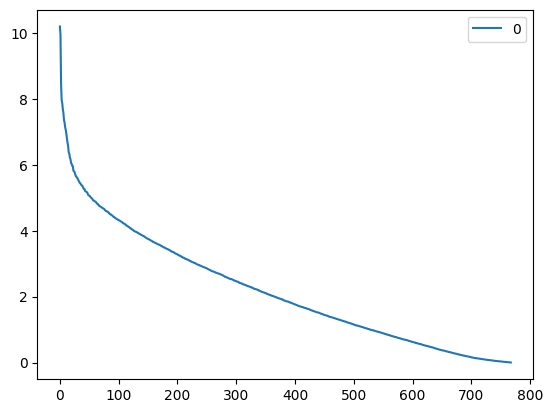

In [10]:
df_s.plot()

In [11]:
df_s.describe()

,0
count,768.000000
mean,2.209294
std,1.757067
min,0.001830
25%,0.746821
50%,1.869588
75%,3.358775
max,10.196619


Text(0.5, 1.0, 'Singular Values')

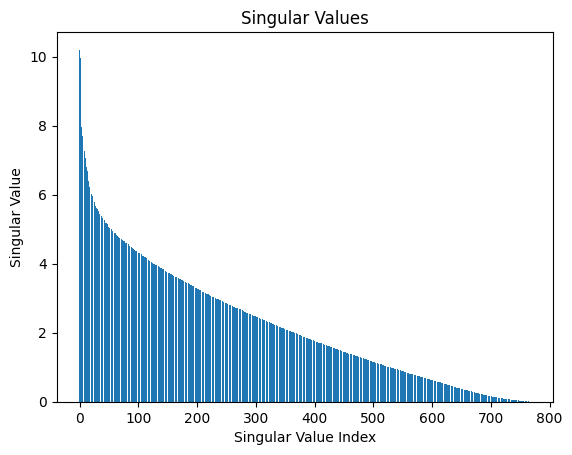

In [12]:
import matplotlib.pyplot as plt
approx_rank = 768
plt.bar(range(approx_rank), s[:approx_rank])
plt.xlabel('Singular Value Index')
plt.ylabel('Singular Value')
plt.title('Singular Values')

In [16]:
# 값의 차분 계산
df_s['difference'] = df_s[0].diff()

# 값이 급격하게 변하는 구간 확인
threshold = 0.1# 원하는 임계값 설정. 이 값을 기준으로 변화량을 판단.
large_diff_indices = df_s[df_s['difference'].abs() > threshold].index

print(large_diff_indices)

Int64Index([1, 2, 3, 5, 6, 7, 9, 11, 12, 13, 15, 17, 19, 23], dtype='int64')


<AxesSubplot:>

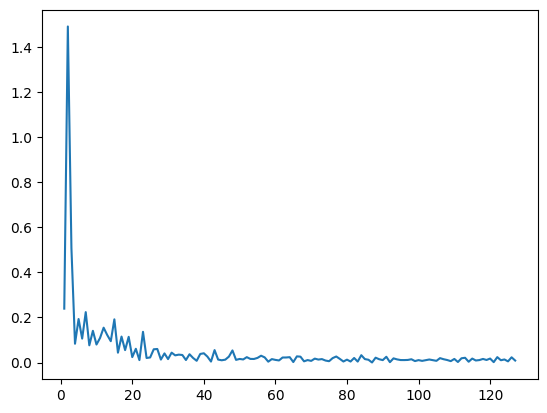

In [20]:
df_s['difference'][:128].abs().plot()

In [25]:
torch.norm(u),torch.norm(torch.diag(s)),torch.norm(vt)

(tensor(27.7128), tensor(78.2083), tensor(27.7128))

In [27]:
df_s_sum = pd.DataFrame(s.numpy())
df_s_sum.head()

,0
0,127.888741
1,74.773071
2,71.333099
3,67.454742
4,66.180603


In [26]:
for i in range(1,12):
    og_weight = model.roberta.encoder.layer[i].attention.self.query.weight.data
    u_temp,s_temp,vt_temp = torch.linalg.svd(og_weight)
    u+=u_temp
    s+=s_temp
    vt+=vt_temp
print(torch.norm(u),torch.norm(torch.diag(s)),torch.norm(vt))

tensor(95.9664) tensor(667.1432) tensor(95.8177)


---

In [4]:
model = AutoModelForSequenceClassification.from_pretrained(
        'textattack/roberta-base-SST-2'
    )
model

Some weights of the model checkpoint at textattack/roberta-base-SST-2 were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [9]:
new_model= copy.deepcopy(AutoModelForSequenceClassification.from_pretrained(
        'textattack/roberta-base-SST-2'
    ))

In [10]:
def insert_lora(model, dim, rank, lora_alpha):
    len_of_layers = 12  # len(model.roberta.encoder)
    for i in range(len_of_layers):
        model.roberta.encoder.layer[i].attention.self.query = copy.deepcopy(
            lora.Linear(dim, dim, r=rank, lora_alpha=lora_alpha, merge_weights=False)
        )
        model.roberta.encoder.layer[i].attention.self.value = copy.deepcopy(
            lora.Linear(dim, dim, r=rank, lora_alpha=lora_alpha, merge_weights=False)
        )

In [7]:
(model.roberta.encoder.layer[0].attention.self.value.weight.data).shape

torch.Size([768, 768])

In [ ]:
encoder_q_original_weight = model.roberta.encoder.layer[0].attention.self.query.weight.data

In [11]:
def dW_init_by_SVD(model, SVD_model, rank):
    w_q_encoder_loraA_weights = []
    w_q_encoder_loraB_weights = []

    w_v_encoder_loraA_weights = []
    w_v_encoder_loraB_weights = []

    len_of_layers = 12  # len(SVD_model.roberta.encoder.layer)
    with torch.no_grad():
        for i in range(len_of_layers):
            encoder_q_original_weight = SVD_model.roberta.encoder.layer[i].attention.self.query.weight.data
            encoder_v_original_weight = SVD_model.roberta.encoder.layer[i].attention.self.value.weight.data

            encoder_q_u, encoder_q_s, encoder_q_v = torch.linalg.svd(encoder_q_original_weight)
            encoder_v_u, encoder_v_s, encoder_v_v = torch.linalg.svd(encoder_v_original_weight)

            approx_rank = rank

            # w_q_encoder
            # torch.Size([768, rank])
            w_q_encoder_loraA_weights.append(
                encoder_q_u[:, :approx_rank] @ torch.diag(encoder_q_s[:approx_rank]).sqrt()
            )
            # torch.Size([rank, 768])
            w_q_encoder_loraB_weights.append(
                torch.diag(encoder_q_s[:approx_rank]).sqrt() @ encoder_q_v[:approx_rank, :]
            )
            # w_v_encoder
            w_v_encoder_loraA_weights.append(
                encoder_v_u[:, :approx_rank] @ torch.diag(encoder_v_s[:approx_rank]).sqrt()
            )
            w_v_encoder_loraB_weights.append(
                torch.diag(encoder_v_s[:approx_rank]).sqrt() @ encoder_v_v[:approx_rank, :]
            )
    og_weight = SVD_model.roberta.encoder.layer[0].attention.self.query.weight.data
    # insert_lora(SVD_model, 768, approx_rank, lora_alpha)

    with torch.no_grad():
        for i in range(len_of_layers):
            model.roberta.encoder.layer[i].attention.self.query.lora_A.copy_(
                w_q_encoder_loraA_weights[i].transpose(0, 1)
            )
            model.roberta.encoder.layer[i].attention.self.query.lora_B.copy_(
                w_q_encoder_loraB_weights[i].transpose(0, 1)
            )

            model.roberta.encoder.layer[i].attention.self.value.lora_A.copy_(
                w_v_encoder_loraA_weights[i].transpose(0, 1)
            )
            model.roberta.encoder.layer[i].attention.self.value.lora_B.copy_(
                w_v_encoder_loraB_weights[i].transpose(0, 1)
            )
    print(f"OG weight Norm : {torch.linalg.norm(og_weight)}")
    approx_weight = (
        model.roberta.encoder.layer[0].attention.self.query.lora_A.T
        @ model.roberta.encoder.layer[0].attention.self.query.lora_B.T
    )
    print(f"recon error between OG and rank_{approx_rank} SVD weight : {recon_error(og_weight,approx_weight)} ")


In [12]:
def W_init_by_loraAB(model, lora_model):
    """
    model의 W weight를 lora_model의 Lora Layer의 weight로 초기화
    """
    len_of_layers = 12
    loraA_q_encoder_weight_list = []
    loraB_q_encoder_weight_list = []

    loraA_v_encoder_weight_list = []
    loraB_v_encoder_weight_list = []

    with torch.no_grad():
        for i in range(len_of_layers):
            loraA_q_encoder_new_weight = lora_model.roberta.encoder.layer[i].attention.self.query.lora_A
            loraA_q_encoder_weight_list.append(loraA_q_encoder_new_weight)
            loraB_q_encoder_new_weight = lora_model.roberta.encoder.layer[i].attention.self.query.lora_B
            loraB_q_encoder_weight_list.append(loraB_q_encoder_new_weight)

            loraA_v_encoder_new_weight = lora_model.roberta.encoder.layer[i].attention.self.value.lora_A
            loraA_v_encoder_weight_list.append(loraA_v_encoder_new_weight)
            loraB_v_encoder_new_weight = lora_model.roberta.encoder.layer[i].attention.self.value.lora_B
            loraB_v_encoder_weight_list.append(loraB_v_encoder_new_weight)

    with torch.no_grad():
        for i in range(len_of_layers):
            model.roberta.encoder.layer[i].attention.self.query.weight.copy_(
                (loraA_q_encoder_weight_list[i].T @ loraB_q_encoder_weight_list[i].T).T
            )

            model.roberta.encoder.layer[i].attention.self.value.weight.copy_(
                (loraA_v_encoder_weight_list[i].T @ loraB_v_encoder_weight_list[i].T).T
            )

In [13]:
model.roberta.encoder.layer[0].attention.self.query.weight.data

tensor([[ 0.0732, -0.0019, -0.0901,  ...,  0.1035,  0.0895, -0.1039],
        [-0.0503,  0.2062,  0.0739,  ...,  0.0655,  0.0638,  0.1283],
        [ 0.0873,  0.0705, -0.0510,  ..., -0.0434, -0.0083,  0.1095],
        ...,
        [-0.1872,  0.0175, -0.0310,  ..., -0.0509,  0.1026, -0.1170],
        [-0.2543,  0.0437,  0.0641,  ...,  0.0709, -0.1043,  0.0117],
        [-0.0517, -0.0858,  0.1024,  ..., -0.1888,  0.0034, -0.0538]])

In [17]:
insert_lora(model, 768, 128, 128)
for i in range(12):
    print(torch.norm(model.roberta.encoder.layer[i].attention.self.query.lora_A),torch.norm(model.roberta.encoder.layer[i].attention.self.query.lora_B))
print(model.roberta.encoder.layer[0].attention.self.query.lora_A)

tensor(6.5303, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(6.5065, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(6.5388, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(6.5455, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(6.5329, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(6.5359, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(6.5215, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(6.5400, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(6.5258, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(6.5298, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(6.5322, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(6.5349, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
Parameter containing:
tensor([[-0.0015,  0.0225,  0.0280,  ..., -0.0284, -0.0101,  0.025

In [40]:
for i in range(12):
    print((model.roberta.encoder.layer[0].attention.self.query.lora_A),(model.roberta.encoder.layer[0].attention.self.query.lora_B))

Parameter containing:
tensor([[-1.9966e-02, -2.0107e-02,  1.0792e-02,  ..., -1.8989e-02,
          3.4663e-02, -1.8569e-02],
        [ 2.4267e-02, -2.2216e-02, -3.4597e-03,  ..., -6.8253e-05,
         -1.4426e-02,  3.3981e-02],
        [ 1.2890e-02, -4.0622e-03,  1.5104e-02,  ...,  8.1993e-03,
          1.2184e-02, -2.1274e-02],
        ...,
        [ 1.7017e-02, -6.0550e-03, -3.2701e-02,  ..., -1.6243e-02,
         -5.2863e-03,  3.4739e-02],
        [-3.4334e-02,  1.9611e-02, -6.6544e-03,  ..., -3.2922e-02,
          1.4811e-02,  3.4774e-02],
        [-2.8915e-02, -2.9844e-02,  2.8870e-02,  ...,  4.2270e-04,
          2.9687e-03, -5.4101e-03]], requires_grad=True) Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)
Parameter containing:
tensor([

In [14]:
print("AFTER INSERT LORA")
model.roberta.encoder.layer[0].attention.self.query.weight.data

AFTER INSERT LORA


tensor([[-0.0260,  0.0036,  0.0135,  ..., -0.0217, -0.0324,  0.0208],
        [ 0.0183,  0.0114, -0.0100,  ...,  0.0274, -0.0075,  0.0359],
        [-0.0166,  0.0352,  0.0215,  ..., -0.0181,  0.0247, -0.0143],
        ...,
        [-0.0098, -0.0138, -0.0200,  ...,  0.0151,  0.0234, -0.0087],
        [-0.0258, -0.0131, -0.0245,  ...,  0.0161, -0.0046,  0.0163],
        [-0.0265, -0.0130,  0.0059,  ...,  0.0115, -0.0178, -0.0350]])

In [17]:
lora_state_dict = torch.load('/home/lab/bumjun/lora-training/LoRA/examples/NLU/sst2/lora/2023-09-11_16:37:03lorackpt.bin')
model.load_state_dict(lora_state_dict, strict=False)
torch.norm(model.roberta.encoder.layer[0].attention.self.query.lora_A),torch.norm(model.roberta.encoder.layer[0].attention.self.query.lora_B)

(tensor(10.9219, grad_fn=<CopyBackwards>),
 tensor(10.8647, grad_fn=<CopyBackwards>))

In [20]:
insert_lora(new_model, 768, 128, 128)
#lora_state_dict = torch.load('/home/lab/bumjun/lora-training/LoRA/examples/NLU/sst2/lora/lorackpt_.bin')
#new_model.load_state_dict(lora_state_dict, strict=False)
for i in range(12):
    print(torch.norm(new_model.roberta.encoder.layer[i].attention.self.query.lora_A-model.roberta.encoder.layer[i].attention.self.query.lora_A))#,torch.norm(new_model.roberta.encoder.layer[i].attention.self.query.lora_B-model.roberta.encoder.layer[i].attention.self.query.lora_B))


tensor(9.2688, grad_fn=<CopyBackwards>)
tensor(9.2465, grad_fn=<CopyBackwards>)
tensor(9.2708, grad_fn=<CopyBackwards>)
tensor(9.2347, grad_fn=<CopyBackwards>)
tensor(9.2479, grad_fn=<CopyBackwards>)
tensor(9.2505, grad_fn=<CopyBackwards>)
tensor(9.2038, grad_fn=<CopyBackwards>)
tensor(9.2329, grad_fn=<CopyBackwards>)
tensor(9.2156, grad_fn=<CopyBackwards>)
tensor(9.2522, grad_fn=<CopyBackwards>)
tensor(9.2205, grad_fn=<CopyBackwards>)
tensor(9.2672, grad_fn=<CopyBackwards>)


In [22]:
model = copy.deepcopy(AutoModelForSequenceClassification.from_pretrained(
        'textattack/roberta-base-SST-2'
    ))
insert_lora(model, 768, 128, 128)
for i in range(12):
    print(torch.norm(model.roberta.encoder.layer[i].attention.self.query.lora_A),torch.norm(model.roberta.encoder.layer[i].attention.self.query.lora_B))
print(model.roberta.encoder.layer[0].attention.self.query.lora_A)

Some weights of the model checkpoint at textattack/roberta-base-SST-2 were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tensor(6.5407, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(6.5271, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(6.5261, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(6.5379, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(6.5217, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(6.5411, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(6.5292, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(6.5453, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(6.5406, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(6.5278, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(6.5377, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(6.5237, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
Parameter containing:
tensor([[-0.0266, -0.0122,  0.0111,  ..., -0.0165,  0.0338,  0.002

In [21]:
new_model= copy.deepcopy(AutoModelForSequenceClassification.from_pretrained(
        'textattack/roberta-base-SST-2'
    ))
insert_lora(new_model, 768, 128, 128)
for i in range(12):
    print(torch.norm(new_model.roberta.encoder.layer[i].attention.self.query.lora_A),torch.norm(new_model.roberta.encoder.layer[i].attention.self.query.lora_B))

Some weights of the model checkpoint at textattack/roberta-base-SST-2 were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tensor(6.5259, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(6.5205, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(6.5330, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(6.5258, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(6.5288, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(6.5455, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(6.5385, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(6.5391, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(6.5260, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(6.5238, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(6.5434, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(6.5411, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)


In [4]:
lora_state_dict = torch.load('/home/lab/bumjun/lora-training/LoRA/examples/NLU/sst2/lora/2023-09-11_16:37:03lorackpt.bin')
lora_state_dict

{'roberta.encoder.layer.0.attention.self.query.lora_A': tensor([[ 0.1515, -0.1323, -0.1244,  ...,  0.0710,  0.1183, -0.0110],
         [-0.1000,  0.0803,  0.2078,  ..., -0.1149,  0.0634, -0.0568],
         [ 0.2582, -0.0209, -0.0885,  ...,  0.0078, -0.0894, -0.0078],
         ...,
         [-0.1884,  0.0715,  0.0927,  ...,  0.1912,  0.0300, -0.2001],
         [-0.0154,  0.0779, -0.0565,  ..., -0.0350,  0.0982, -0.0041],
         [ 0.0760, -0.0409,  0.1545,  ...,  0.0343,  0.0311, -0.0163]],
        device='cuda:0'),
 'roberta.encoder.layer.0.attention.self.query.lora_B': tensor([[-0.0154,  0.0150,  0.1466,  ..., -0.0155,  0.0818, -0.1649],
         [ 0.0124, -0.0048, -0.0017,  ..., -0.0034,  0.0430,  0.0365],
         [-0.0030,  0.0033, -0.1092,  ...,  0.0135,  0.0124,  0.1118],
         ...,
         [-0.0446,  0.0194,  0.2464,  ..., -0.1759,  0.2416,  0.1392],
         [ 0.0507,  0.0158, -0.1048,  ...,  0.0168, -0.0128, -0.2386],
         [ 0.0126,  0.0374, -0.0804,  ...,  0.0669,  0

In [13]:
for i in range(12):
    lora_state_dict[f'roberta.encoder.layer.{i}.attention.self.query.lora_A']
    #print(lora_state_dict[f'roberta.encoder.layer.{i}.attention.self.query.lora_B'])

tensor(10.9219, device='cuda:0')
tensor(9.6851, device='cuda:0')
tensor(9.1127, device='cuda:0')
tensor(9.2301, device='cuda:0')
tensor(9.3997, device='cuda:0')
tensor(8.9274, device='cuda:0')
tensor(8.9530, device='cuda:0')
tensor(9.2583, device='cuda:0')
tensor(8.9385, device='cuda:0')
tensor(9.1729, device='cuda:0')
tensor(8.7749, device='cuda:0')
tensor(9.0307, device='cuda:0')


In [15]:
print(lora_state_dict.keys())

dict_keys(['roberta.encoder.layer.0.attention.self.query.lora_A', 'roberta.encoder.layer.0.attention.self.query.lora_B', 'roberta.encoder.layer.0.attention.self.value.lora_A', 'roberta.encoder.layer.0.attention.self.value.lora_B', 'roberta.encoder.layer.1.attention.self.query.lora_A', 'roberta.encoder.layer.1.attention.self.query.lora_B', 'roberta.encoder.layer.1.attention.self.value.lora_A', 'roberta.encoder.layer.1.attention.self.value.lora_B', 'roberta.encoder.layer.2.attention.self.query.lora_A', 'roberta.encoder.layer.2.attention.self.query.lora_B', 'roberta.encoder.layer.2.attention.self.value.lora_A', 'roberta.encoder.layer.2.attention.self.value.lora_B', 'roberta.encoder.layer.3.attention.self.query.lora_A', 'roberta.encoder.layer.3.attention.self.query.lora_B', 'roberta.encoder.layer.3.attention.self.value.lora_A', 'roberta.encoder.layer.3.attention.self.value.lora_B', 'roberta.encoder.layer.4.attention.self.query.lora_A', 'roberta.encoder.layer.4.attention.self.query.lora_B',

In [8]:
model.classifier.out_proj.weight.data

tensor([[-0.0010, -0.0341,  0.0157,  ...,  0.0277, -0.0258, -0.0136],
        [ 0.0313, -0.0277, -0.0190,  ..., -0.0073,  0.0265, -0.0225]])

In [16]:
print("AFTER LOAD LORA")
model.roberta.encoder.layer[0].attention.self.value.weight.data

AFTER LOAD LORA


tensor([[ 0.0322, -0.0359, -0.0232,  ...,  0.0358,  0.0125,  0.0275],
        [-0.0214, -0.0352, -0.0192,  ...,  0.0032, -0.0262, -0.0343],
        [ 0.0182,  0.0004, -0.0124,  ...,  0.0281,  0.0066, -0.0108],
        ...,
        [-0.0222, -0.0039,  0.0108,  ...,  0.0196,  0.0040,  0.0186],
        [ 0.0353,  0.0337,  0.0345,  ...,  0.0277,  0.0004,  0.0060],
        [ 0.0220,  0.0234, -0.0042,  ...,  0.0074,  0.0276, -0.0044]])

In [24]:
new_model = copy.deepcopy(AutoModelForSequenceClassification.from_pretrained(
        'textattack/roberta-base-SST-2'
    ))

Some weights of the model checkpoint at textattack/roberta-base-SST-2 were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
def W_weight_copy(new_model, W_model):
    len_of_layers = 12
    q_encoder_weight_list = []
    v_encoder_weight_list = []
    q_encoder_bias_list = []
    v_encoder_bias_list = []

    for i in range(len_of_layers):
        q_encoder_new_weight = W_model.roberta.encoder.layer[i].attention.self.query.weight.data
        q_encoder_weight_list.append(q_encoder_new_weight)
        q_encoder_new_bias = W_model.roberta.encoder.layer[i].attention.self.query.bias.data
        q_encoder_bias_list.append(q_encoder_new_bias)

        v_encoder_new_weight = W_model.roberta.encoder.layer[i].attention.self.value.weight.data
        v_encoder_weight_list.append(v_encoder_new_weight)
        v_encoder_new_bias = W_model.roberta.encoder.layer[i].attention.self.value.bias.data
        v_encoder_bias_list.append(v_encoder_new_bias)

    with torch.no_grad():
        for i in range(len_of_layers):
            new_model.roberta.encoder.layer[i].attention.self.query.weight.data.copy_(q_encoder_weight_list[i])
            new_model.roberta.encoder.layer[i].attention.self.value.weight.data.copy_(v_encoder_weight_list[i])
            new_model.roberta.encoder.layer[i].attention.self.query.bias.data.copy_(q_encoder_bias_list[i])
            new_model.roberta.encoder.layer[i].attention.self.value.bias.data.copy_(v_encoder_bias_list[i])

In [15]:
model.roberta.encoder.layer[0].attention.self.query.weight.data

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [16]:
W_weight_copy(model, new_model)
model.roberta.encoder.layer[0].attention.self.query.weight.data

tensor([[ 0.0732, -0.0019, -0.0901,  ...,  0.1035,  0.0895, -0.1039],
        [-0.0503,  0.2062,  0.0739,  ...,  0.0655,  0.0638,  0.1283],
        [ 0.0873,  0.0705, -0.0510,  ..., -0.0434, -0.0083,  0.1095],
        ...,
        [-0.1872,  0.0175, -0.0310,  ..., -0.0509,  0.1026, -0.1170],
        [-0.2543,  0.0437,  0.0641,  ...,  0.0709, -0.1043,  0.0117],
        [-0.0517, -0.0858,  0.1024,  ..., -0.1888,  0.0034, -0.0538]])

In [17]:
for i in range(12):
    print( torch.norm(model.roberta.encoder.layer[i].attention.self.query.weight.data), torch.norm(model.roberta.encoder.layer[i].attention.self.query.weight.data))

tensor(78.2082) tensor(78.2082)
tensor(57.5268) tensor(57.5268)
tensor(52.0564) tensor(52.0564)
tensor(55.0221) tensor(55.0221)
tensor(56.1601) tensor(56.1601)
tensor(52.9273) tensor(52.9273)
tensor(52.9121) tensor(52.9121)
tensor(56.8583) tensor(56.8583)
tensor(51.9982) tensor(51.9982)
tensor(50.7544) tensor(50.7544)
tensor(51.3512) tensor(51.3512)
tensor(52.4352) tensor(52.4352)


In [19]:
for i in range(12):
    print( torch.norm(model.roberta.encoder.layer[i].attention.self.key.weight.data), torch.norm(model.roberta.encoder.layer[i].attention.self.key.weight.data))

tensor(77.4265) tensor(77.4265)
tensor(56.4624) tensor(56.4624)
tensor(51.3908) tensor(51.3908)
tensor(53.2840) tensor(53.2840)
tensor(54.1298) tensor(54.1298)
tensor(51.0863) tensor(51.0863)
tensor(51.0968) tensor(51.0968)
tensor(55.2711) tensor(55.2711)
tensor(50.8302) tensor(50.8302)
tensor(49.9693) tensor(49.9693)
tensor(49.5151) tensor(49.5151)
tensor(51.6066) tensor(51.6066)


In [31]:
insert_lora(new_model, 768, 16, 16)
#lora_state_dict = torch.load('/home/lab/bumjun/lora-training/LoRA/examples/NLU/sst2/r64r64r64/model/checkpoint-13175/pytorch_model.bin')
#new_model.load_state_dict(lora_state_dict, strict=False)
torch.norm(new_model.roberta.encoder.layer[0].attention.self.query.lora_A),torch.norm(new_model.roberta.encoder.layer[0].attention.self.query.lora_B)


(tensor(2.3070, grad_fn=<CopyBackwards>), tensor(0., grad_fn=<CopyBackwards>))

In [19]:
for i in range(12):
    print( torch.norm(model.roberta.encoder.layer[i].attention.self.query.lora_A), torch.norm(model.roberta.encoder.layer[i].attention.self.query.lora_B))

tensor(10.9219, grad_fn=<CopyBackwards>) tensor(10.8647, grad_fn=<CopyBackwards>)
tensor(9.6851, grad_fn=<CopyBackwards>) tensor(9.6469, grad_fn=<CopyBackwards>)
tensor(9.1127, grad_fn=<CopyBackwards>) tensor(9.0218, grad_fn=<CopyBackwards>)
tensor(9.2301, grad_fn=<CopyBackwards>) tensor(9.2332, grad_fn=<CopyBackwards>)
tensor(9.3997, grad_fn=<CopyBackwards>) tensor(9.3910, grad_fn=<CopyBackwards>)
tensor(8.9274, grad_fn=<CopyBackwards>) tensor(8.9347, grad_fn=<CopyBackwards>)
tensor(8.9530, grad_fn=<CopyBackwards>) tensor(8.9259, grad_fn=<CopyBackwards>)
tensor(9.2584, grad_fn=<CopyBackwards>) tensor(9.2404, grad_fn=<CopyBackwards>)
tensor(8.9385, grad_fn=<CopyBackwards>) tensor(8.9553, grad_fn=<CopyBackwards>)
tensor(9.1729, grad_fn=<CopyBackwards>) tensor(9.1983, grad_fn=<CopyBackwards>)
tensor(8.7749, grad_fn=<CopyBackwards>) tensor(8.7662, grad_fn=<CopyBackwards>)
tensor(9.0308, grad_fn=<CopyBackwards>) tensor(9.0136, grad_fn=<CopyBackwards>)


In [31]:
model.roberta.encoder.layer[i].attention.self.query.lora_A.shape, new_model.roberta.encoder.layer[i].attention.self.query.lora_A.shape

(torch.Size([16, 768]), torch.Size([128, 768]))

In [32]:
for i in range(12):
    print( torch.norm(new_model.roberta.encoder.layer[i].attention.self.query.lora_A), torch.norm(new_model.roberta.encoder.layer[i].attention.self.query.lora_B))

tensor(2.3070, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(2.2959, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(2.3106, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(2.3133, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(2.3033, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(2.3186, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(2.3104, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(2.2942, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(2.3172, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(2.3137, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(2.2999, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)
tensor(2.3121, grad_fn=<CopyBackwards>) tensor(0., grad_fn=<CopyBackwards>)


In [34]:
for i in range(12):
    print(new_model.roberta.encoder.layer[i].attention.self.value.lora_A)

Parameter containing:
tensor([[ 0.0139,  0.0295, -0.0040,  ..., -0.0151, -0.0048, -0.0237],
        [ 0.0140, -0.0060, -0.0127,  ..., -0.0104, -0.0056,  0.0150],
        [-0.0277, -0.0122,  0.0181,  ..., -0.0182, -0.0130, -0.0210],
        ...,
        [-0.0322, -0.0211, -0.0048,  ...,  0.0252, -0.0280, -0.0230],
        [ 0.0040, -0.0131,  0.0132,  ..., -0.0281, -0.0081,  0.0275],
        [ 0.0028,  0.0217,  0.0232,  ..., -0.0175, -0.0163,  0.0122]],
       requires_grad=True)
Parameter containing:
tensor([[ 0.0014,  0.0105,  0.0071,  ...,  0.0169,  0.0251,  0.0073],
        [ 0.0359,  0.0251, -0.0356,  ..., -0.0108,  0.0021,  0.0284],
        [ 0.0264,  0.0078, -0.0033,  ...,  0.0056, -0.0003,  0.0356],
        ...,
        [ 0.0086,  0.0262, -0.0339,  ..., -0.0129,  0.0065, -0.0028],
        [ 0.0032,  0.0008, -0.0006,  ...,  0.0216,  0.0007,  0.0063],
        [-0.0142, -0.0030, -0.0137,  ..., -0.0214,  0.0346,  0.0010]],
       requires_grad=True)
Parameter containing:
tensor([[-0.

In [28]:
for i in range(12):
    print( torch.norm(new_model.roberta.encoder.layer[i].attention.self.value.lora_A), torch.norm(new_model.roberta.encoder.layer[i].attention.self.value.lora_B))

tensor(7.7123, grad_fn=<CopyBackwards>) tensor(3.4013, grad_fn=<CopyBackwards>)
tensor(7.8495, grad_fn=<CopyBackwards>) tensor(3.0643, grad_fn=<CopyBackwards>)
tensor(7.6633, grad_fn=<CopyBackwards>) tensor(3.0875, grad_fn=<CopyBackwards>)
tensor(7.1175, grad_fn=<CopyBackwards>) tensor(2.5886, grad_fn=<CopyBackwards>)
tensor(6.9871, grad_fn=<CopyBackwards>) tensor(2.4708, grad_fn=<CopyBackwards>)
tensor(6.8683, grad_fn=<CopyBackwards>) tensor(2.4792, grad_fn=<CopyBackwards>)
tensor(6.8484, grad_fn=<CopyBackwards>) tensor(2.4745, grad_fn=<CopyBackwards>)
tensor(7.1846, grad_fn=<CopyBackwards>) tensor(2.8878, grad_fn=<CopyBackwards>)
tensor(6.9876, grad_fn=<CopyBackwards>) tensor(2.8358, grad_fn=<CopyBackwards>)
tensor(6.8469, grad_fn=<CopyBackwards>) tensor(2.7624, grad_fn=<CopyBackwards>)
tensor(6.6812, grad_fn=<CopyBackwards>) tensor(2.3723, grad_fn=<CopyBackwards>)
tensor(6.5843, grad_fn=<CopyBackwards>) tensor(2.1620, grad_fn=<CopyBackwards>)


In [18]:
new_model.roberta.encoder.layer[0].attention.self.query.lora_A

Parameter containing:
tensor([[-0.0113, -0.0016,  0.0347,  ...,  0.0439, -0.0025,  0.0073],
        [ 0.0090,  0.0445, -0.0361,  ...,  0.0181, -0.0119,  0.0049],
        [ 0.0282,  0.0265,  0.0351,  ...,  0.0181,  0.0378, -0.0296],
        ...,
        [ 0.0468,  0.0065, -0.0446,  ..., -0.0098,  0.0433, -0.0173],
        [-0.0202,  0.0192,  0.0144,  ...,  0.0267, -0.0055,  0.0240],
        [-0.0377,  0.0324, -0.0446,  ..., -0.0368, -0.0095,  0.0393]],
       requires_grad=True)

In [19]:
model.roberta.encoder.layer[0].attention.self.query.lora_A

Parameter containing:
tensor([[ 0.1517, -0.1326, -0.1234,  ...,  0.0705,  0.1163, -0.0122],
        [-0.1000,  0.0818,  0.2082,  ..., -0.1151,  0.0634, -0.0582],
        [ 0.2597, -0.0216, -0.0885,  ...,  0.0084, -0.0894, -0.0085],
        ...,
        [-0.1887,  0.0710,  0.0932,  ...,  0.1906,  0.0301, -0.2001],
        [-0.0157,  0.0772, -0.0567,  ..., -0.0360,  0.0985, -0.0041],
        [ 0.0767, -0.0417,  0.1543,  ...,  0.0336,  0.0307, -0.0174]],
       requires_grad=True)

In [22]:
new_model.roberta.encoder.layer[0].attention.self.query.weight.data

tensor([[ 0.0423,  0.0066, -0.0447,  ..., -0.0113,  0.0029, -0.1085],
        [-0.0053, -0.0050, -0.0031,  ..., -0.0049,  0.0114,  0.0038],
        [-0.0326, -0.0065,  0.0312,  ..., -0.0037,  0.0191,  0.0202],
        ...,
        [-0.0352,  0.0125,  0.0243,  ..., -0.0509,  0.0318, -0.0567],
        [-0.0132,  0.0274, -0.0442,  ...,  0.0136, -0.0051, -0.0123],
        [-0.0514,  0.0142, -0.0271,  ...,  0.0021,  0.0060,  0.0020]])

In [23]:
W_init_by_loraAB(new_model, model)
new_model.roberta.encoder.layer[0].attention.self.query.weight.data

tensor([[ 0.0423,  0.0066, -0.0447,  ..., -0.0113,  0.0029, -0.1085],
        [-0.0053, -0.0050, -0.0031,  ..., -0.0049,  0.0114,  0.0038],
        [-0.0326, -0.0065,  0.0312,  ..., -0.0037,  0.0191,  0.0202],
        ...,
        [-0.0352,  0.0125,  0.0243,  ..., -0.0509,  0.0318, -0.0567],
        [-0.0132,  0.0274, -0.0442,  ...,  0.0136, -0.0051, -0.0123],
        [-0.0514,  0.0142, -0.0271,  ...,  0.0021,  0.0060,  0.0020]])

In [25]:
model.roberta.encoder.layer[0].attention.self.query.lora_A.T @ model.roberta.encoder.layer[0].attention.self.query.lora_B.T

tensor([[ 0.0423, -0.0053, -0.0326,  ..., -0.0352, -0.0132, -0.0514],
        [ 0.0066, -0.0050, -0.0065,  ...,  0.0125,  0.0274,  0.0142],
        [-0.0447, -0.0031,  0.0312,  ...,  0.0243, -0.0442, -0.0271],
        ...,
        [-0.0113, -0.0049, -0.0037,  ..., -0.0509,  0.0136,  0.0021],
        [ 0.0029,  0.0114,  0.0191,  ...,  0.0318, -0.0051,  0.0060],
        [-0.1085,  0.0038,  0.0202,  ..., -0.0567, -0.0123,  0.0020]],
       grad_fn=<MmBackward>)

In [ ]:
new_model = copy.deepcopy(model)
insert_lora(model, 768, model_args.lora_r, model_args.lora_alpha)
# print(model.roberta.encoder.layer[0].attention.self.query.bias)
W_weight_copy(model, new_model)
# print(model.roberta.encoder.layer[0].attention.self.query.bias)
trainable_params = []
# if model_args.apply_lora:
#     if model_args.lora_path is not None:
#         lora_state_dict = torch.load(model_args.lora_path)
#         logger.info(f"Apply LoRA state dict from {model_args.lora_path}.")
#         logger.info(lora_state_dict.keys())
#         model.load_state_dict(lora_state_dict, strict=False)
#     model.load_state_dict(torch.load(model_args.lora_path), strict=False)
# trainable_params.append("lora")
print("BEFORE INIT LORA")
print(
    model.roberta.encoder.layer[0].attention.self.query.lora_A,
    model.roberta.encoder.layer[0].attention.self.query.lora_B,
)
# dW_init_by_SVD(model, new_model, model_args.lora_r)
w_q_encoder_loraA_weights = []
w_q_encoder_loraB_weights = []
w_v_encoder_loraA_weights = []
w_v_encoder_loraB_weights = []
len_of_layers = 12  # len(SVD_model.roberta.encoder.layer)
with torch.no_grad():
    for i in range(len_of_layers):
        encoder_q_original_weight = new_model.roberta.encoder.layer[i].attention.self.query.weight.data.T
        encoder_v_original_weight = new_model.roberta.encoder.layer[i].attention.self.value.weight.data.T
        encoder_q_u, encoder_q_s, encoder_q_v = torch.linalg.svd(encoder_q_original_weight)
        encoder_v_u, encoder_v_s, encoder_v_v = torch.linalg.svd(encoder_v_original_weight)
        approx_rank = model_args.lora_r
        # w_q_encoder
        # torch.Size([768, rank])
        w_q_encoder_loraA_weights.append(
            encoder_q_u[:, :approx_rank] @ torch.diag(encoder_q_s[:approx_rank]).sqrt()
        )
        # torch.Size([rank, 768])
        w_q_encoder_loraB_weights.append(
            torch.diag(encoder_q_s[:approx_rank]).sqrt() @ encoder_q_v[:approx_rank, :]
        )
        # w_v_encoder
        w_v_encoder_loraA_weights.append(
            encoder_v_u[:, :approx_rank] @ torch.diag(encoder_v_s[:approx_rank]).sqrt()
        )
        w_v_encoder_loraB_weights.append(
            torch.diag(encoder_v_s[:approx_rank]).sqrt() @ encoder_v_v[:approx_rank, :]
        )
og_weight = new_model.roberta.encoder.layer[0].attention.self.query.weight.data
with torch.no_grad():
    for i in range(len_of_layers):
        model.roberta.encoder.layer[i].attention.self.query.lora_A.copy_(w_q_encoder_loraA_weights[i].T)
        model.roberta.encoder.layer[i].attention.self.query.lora_B.copy_(w_q_encoder_loraB_weights[i].T)
        model.roberta.encoder.layer[i].attention.self.value.lora_A.copy_(w_v_encoder_loraA_weights[i].T)
        model.roberta.encoder.layer[i].attention.self.value.lora_B.copy_(w_v_encoder_loraB_weights[i].T)

In [1]:
import torch
from dataclasses import dataclass, field
from typing import Optional

import numpy as np
from datasets import load_dataset, load_metric

# import transformers
# from transformers import (
#     AutoConfig,
#     AutoModelForSequenceClassification, 
#     AutoTokenizer,
#     DataCollatorWithPadding,
#     EvalPrediction,
#     HfArgumentParser,
#     PretrainedConfig,
#     Trainer,
#     TrainingArguments,
#     default_data_collator,
#     set_seed,
#     EarlyStoppingCallback,
#     integrations,
# )
# from transformers.trainer_utils import get_last_checkpoint, is_main_process
# from transformers.utils import check_min_version

import wandb
from wandb import AlertLevel
import loralib as lora
import copy
import torch.nn as nn
import math


InvalidVersion: Invalid version: '0.10.1,<0.11'

In [ ]:
def add_lora_to_roberta(model, dim, rank, lora_alpha):
    len_of_layers = len(model.roberta.encoder.layer)  # len(model.roberta.encoder)
    for i in range(len_of_layers):
        model.roberta.encoder.layer[i].attention.self.query = copy.deepcopy(
            lora.Linear(dim, dim, r=rank, lora_alpha=lora_alpha, merge_weights=False)
        )
        model.roberta.encoder.layer[i].attention.self.value = copy.deepcopy(
            lora.Linear(dim, dim, r=rank, lora_alpha=lora_alpha, merge_weights=False)
        )


def copy_weights(new_model, W_model):
    """
    W_model의 W weight를 new_model의 W weight로 복사
    """
    len_of_layers = 12
    q_encoder_weight_list = []
    v_encoder_weight_list = []
    q_encoder_bias_list = []
    v_encoder_bias_list = []

    for i in range(len_of_layers):
        q_encoder_new_weight = W_model.roberta.encoder.layer[i].attention.self.query.weight.data
        q_encoder_weight_list.append(q_encoder_new_weight)
        q_encoder_new_bias = W_model.roberta.encoder.layer[i].attention.self.query.bias.data
        q_encoder_bias_list.append(q_encoder_new_bias)

        v_encoder_new_weight = W_model.roberta.encoder.layer[i].attention.self.value.weight.data
        v_encoder_weight_list.append(v_encoder_new_weight)
        v_encoder_new_bias = W_model.roberta.encoder.layer[i].attention.self.value.bias.data
        v_encoder_bias_list.append(v_encoder_new_bias)

    with torch.no_grad():
        for i in range(len_of_layers):
            new_model.roberta.encoder.layer[i].attention.self.query.weight.data.copy_(q_encoder_weight_list[i])
            new_model.roberta.encoder.layer[i].attention.self.value.weight.data.copy_(v_encoder_weight_list[i])
            new_model.roberta.encoder.layer[i].attention.self.query.bias.data.copy_(q_encoder_bias_list[i])
            new_model.roberta.encoder.layer[i].attention.self.value.bias.data.copy_(v_encoder_bias_list[i])



In [ ]:
model = copy.deepcopy(
        AutoModelForSequenceClassification.from_pretrained(
            "roberta-base",
        )
    )

In [ ]:
add_lora_to_roberta(model, 768, 8.16)
copy_weights(model, new_model)
model.load_state_dict(torch.load("/home/lab/bumjun/low_rank/examples/NLU/LoRA_ckpt_from_repo/roberta_base_lora_cola.bin"), strict=False)